<a href="https://colab.research.google.com/github/jeffrey82221/colab/blob/main/PracticeML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 練習題 I: GridSearch練習

說明：

在08_M8課程中，我們使用LightGBM 來示範 GridSearch(網格搜索法)，對Book_Purchased進行建模。本練習題中，希望各位學員能以Xgboost來進行葡萄牙銀行的電話營銷成功與否的預測，並以GridSearch對Xgboost中的參數進行最優化的自動搜尋。



Ref: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8



# 資料下載：

---

https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv


該數據集來自 UCI 機器學習存儲庫，是關於葡萄牙銀行的電話營銷活動。分類目標是預測客戶是否會訂閱定期存款（變量 y：0/1）。

In [4]:
!wget https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv

--2022-01-20 11:40:33--  https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4882918 (4.7M) [text/plain]
Saving to: ‘banking.csv.1’

banking.csv.1       100%[===================>]   4.66M  --.-KB/s    in 0.02s   

2022-01-20 11:40:33 (243 MB/s) - ‘banking.csv.1’ saved [4882918/4882918]



# 資料檢視

---

1. age (numeric)
2. job : type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)
3. marital : marital status (categorical: “divorced”, “married”, “single”, “unknown”)
4. education (categorical: “basic.4y”, “basic.6y”, “basic.9y”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)
5. default: has credit in default? (categorical: “no”, “yes”, “unknown”)
6. housing: has housing loan? (categorical: “no”, “yes”, “unknown”)
7. loan: has personal loan? (categorical: “no”, “yes”, “unknown”)
8. contact: contact communication type (categorical: “cellular”, “telephone”)
9. month: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)
10. day_of_week: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)
16. emp.var.rate: employment variation rate — (numeric)
17. cons.price.idx: consumer price index — (numeric)
18. cons.conf.idx: consumer confidence index — (numeric)
19. euribor3m: euribor 3 month rate — (numeric)
20. nr.employed: number of employees — (numeric)



In [5]:
import pandas as pd
data = pd.read_csv('banking.csv')
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,222,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1,0
41184,31,housemaid,married,basic.4y,unknown,no,no,telephone,may,thu,196,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,62,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,200,2,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,0


# 資料處理

--- 
1. 合併基礎教育程度 
2. 將類別型欄位進行One-hot Encoding
3. 萃取出X,y
4. 切分出training/testing資料集


In [6]:
import numpy as np
# 合併基礎教育程度 (basic.9y/basic.6y/basic.4y -> Basic)
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])
# 將類別型欄位進行One-hot Encoding
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data[to_keep]
# 萃取出X,y
x_cols = [col for col in data_final.columns.tolist() if col != 'y']
x_data = data_final[x_cols]
y_data = data_final['y']
X = x_data.values
y = y_data.values
# 切分出training/testing資料集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# 建立 Xgboost 模型並進行GridSearch

Ref: https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

In [7]:
# [Step.1.] 建立XGBoostClassifer，objective請使用'binary:logistic'
classifier = None
from xgboost import XGBClassifier
classifier = XGBClassifier(objective='binary:logistic')
# [Step.2.] 建立參數搜尋空間 (因課程時間有限，請挑選三個參數進行搜尋，每個參數給兩個選項即可)
# 提示: 用 help(classifier.__init__) 和 help(classifier) 查詢XGBClassifier所用到的參數
param_grid = {}
param_grid = {
    # 'max_depth': [3, 4, 5], 
    # 'learning_rate': [1.0, 0.1, 0.01, 0.001],
    'n_estimators': [100, 500],
    'min_child_weight': [1, 10],
    'gamma': [0.5, 1.5],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0]
}
# [Step.3.] 建立gridsearch物件 (輸入: classifier, param_grid)
gridsearch = None
from sklearn.model_selection import GridSearchCV
gridsearch = GridSearchCV(classifier, param_grid, verbose=3)

# [Step.4.] 執行gridsearch
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END gamma=0.5, min_child_weight=1, n_estimators=100;, score=0.918 total time=   3.5s
[CV 2/5] END gamma=0.5, min_child_weight=1, n_estimators=100;, score=0.916 total time=   3.5s
[CV 3/5] END gamma=0.5, min_child_weight=1, n_estimators=100;, score=0.910 total time=   3.4s
[CV 4/5] END gamma=0.5, min_child_weight=1, n_estimators=100;, score=0.915 total time=   3.4s
[CV 5/5] END gamma=0.5, min_child_weight=1, n_estimators=100;, score=0.913 total time=   3.4s
[CV 1/5] END gamma=0.5, min_child_weight=1, n_estimators=500;, score=0.920 total time=  16.4s
[CV 2/5] END gamma=0.5, min_child_weight=1, n_estimators=500;, score=0.915 total time=  16.5s
[CV 3/5] END gamma=0.5, min_child_weight=1, n_estimators=500;, score=0.911 total time=  16.3s
[CV 4/5] END gamma=0.5, min_child_weight=1, n_estimators=500;, score=0.916 total time=  16.3s
[CV 5/5] END gamma=0.5, min_child_weight=1, n_estimators=500;, score=0.915 total time=  16.4s


GridSearchCV(estimator=XGBClassifier(),
             param_grid={'gamma': [0.5, 1.5], 'min_child_weight': [1, 10],
                         'n_estimators': [100, 500]},
             verbose=3)

# 訓練結果檢視

---

1. 請給定gridsearch所找到的最佳參數給xgboost進行訓練

2. 訓練完畢請對test資料進行預測，並觀察feature importance的合理性。


In [8]:
print('Start predicting...')
# [Step.5.] 填入最佳參數給xgboost進行建模與預測
xgboost_cls = XGBClassifier(objective = 'binary:logistic',
              n_estimators = gridsearch.best_params_['n_estimators'],
              min_child_weight = gridsearch.best_params_['min_child_weight'], 
              gamma = gridsearch.best_params_['gamma'])
%time xgboost_fit = xgboost_cls.fit(X_train, y_train)
print('Predicting is over')
# [Step.6.] 成效運算
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

XGBoost_grid_measure = measure_performance(X=X_test, y=y_test, clf=xgboost_fit, 
          show_classification_report=True, show_confusion_matrix=True)

# [Step.7.] 建立因子重要性表格，觀察因子重要性是否合理。
importance_table = pd.DataFrame([x_data.columns, xgboost_fit.feature_importances_]).T
importance_table.rename(columns={0: 'column', 1: 'importance'}, inplace=True)
importance_table.sort_values('importance',ascending=False, inplace=True)
importance_table.head(20)

Start predicting...
CPU times: user 20.6 s, sys: 105 ms, total: 20.7 s
Wall time: 20.6 s
Predicting is over
Accuracy:0.918
Classification report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      9156
           1       0.66      0.54      0.59      1141

    accuracy                           0.92     10297
   macro avg       0.80      0.75      0.77     10297
weighted avg       0.91      0.92      0.91     10297

Confusion matrix
[[8844  312]
 [ 529  612]]
ROC AUC Score
0.9481265236437345


,column,importance
9,nr_employed,0.433514
1,duration,0.0670676
5,emp_var_rate,0.0551363
49,month_may,0.038391
60,poutcome_success,0.0362011
7,cons_conf_idx,0.0301967
51,month_oct,0.0267932
3,pdays,0.0228921
48,month_mar,0.0198431
32,default_no,0.0175379


# 練習題 II: SHAP模型解釋練習

這裡請學員承接練習題I所產出之Xgboost模型，以SHAP套件進行電話營銷模型的解釋。

In [9]:
!pip install shap

In [10]:
import shap
# [Step 1] 輸入xgboost_cls產生shap.Explainer物件 
explainer = None
explainer = shap.Explainer(xgboost_cls)
# [Step 2] 使用explainer產生shap_values
shap_values = None
shap_values = explainer(x_data)

# 資料解釋




## 畫出waterfall 

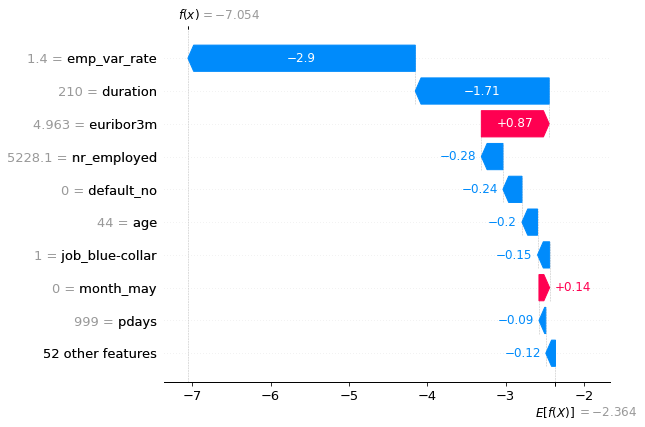

In [11]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values.values, x_data)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


In [1]:
shap.summary_plot(shap_values, x_data)

NameError: ignored

In [15]:
shap.force_plot(explainer.expected_value, shap_values.values[0:5,:],x_data.iloc[0:5,:], plot_cmap="DrDb")

AttributeError: ignored

In [ ]:
shap.force_plot(explainer.expected_value, shap_values.values, x_data, plot_cmap="DrDb")


shap.plots.force is slow for many thousands of rows, try subsampling your data.


In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values[:,"VIP"])
